In [1]:
#loading libraries
suppressMessages(library("DESeq2"))
suppressMessages(library(edgeR))
suppressMessages(library(lubridate))
suppressMessages(library(dplyr))
suppressMessages(library(tidyverse))
suppressMessages(library(gsheet))
suppressMessages(library(data.table))
suppressMessages(library(vegan))
suppressMessages(library(EnvStats))
suppressMessages(library(stringr))

Warning message:
“package ‘gsheet’ was built under R version 4.2.2”
Warning message:
“package ‘vegan’ was built under R version 4.2.2”
Warning message:
“package ‘permute’ was built under R version 4.1.3”
Warning message:
“package ‘EnvStats’ was built under R version 4.2.2”


In [2]:
samples_after_QC = fread("/workdir/omm35/paper_urine_cfrna/metadata/QC_pass_samples.csv")

In [4]:
files = list.files(path="/workdir/omm35/paper_urine_cfrna", recursive = TRUE, pattern = "*feature_counts.tsv", full.names = TRUE)
files
counts = lapply(files,fread)
common_column <- "geneID"
counts <- Reduce(function(x, y) merge(x, y, by = common_column, all.x = TRUE), counts)

[1] "/workdir/omm35/paper_urine_cfrna/aki_plasma/aki_cfrna_plasma_feature_counts.tsv"  
[2] "/workdir/omm35/paper_urine_cfrna/aki_urine/AKI_urine_feature_counts.tsv"          
[3] "/workdir/omm35/paper_urine_cfrna/gvhd_plasma/gvhd_hct_feature_counts.tsv"         
[4] "/workdir/omm35/paper_urine_cfrna/gvhd_urine/GVHD_feature_counts.tsv"              
[5] "/workdir/omm35/paper_urine_cfrna/healthy_plasma/healthy_plasma_feature_counts.tsv"
[6] "/workdir/omm35/paper_urine_cfrna/healthy_urine/healthy_urine_feature_counts.tsv"  
[7] "/workdir/omm35/paper_urine_cfrna/ktx_urine/KTx_feature_counts.tsv"

In [8]:
samples_after_QC = samples_after_QC %>% filter(biofluid=="healthy_urine" | biofluid=="healthy_plasma")
counts = counts %>% dplyr::select(geneID,one_of(samples_after_QC$sample_id))
counts = column_to_rownames(counts, var = "geneID")

In [11]:
samples_after_QC$volunteer=gsub("\\D","",samples_after_QC$sample_id)

sample_id,reads_all,reads_trimmed_filtered,align_input,align_unique,align_multi,align_tooshort,duplication_rate,ftcount,bias53,⋯,intergenic_reads,rRNA_reads,mtRNA_reads,nuclear_reads,biofluid,ribosomal_percentage,mean_bias,sd_bias,Z_score_bias53,volunteer
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,⋯,<dbl>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
irb-p-cfrna-1-A,19534623,19527378,19503739,5011916,3014738,11363654,0.4820633,1558164,1.30,⋯,997741.0,465978,374834,2460648,healthy_plasma,2.3891727,1.196667,0.04334499,2.38397427,1
irb-p-cfrna-2-A,21801465,21785055,21716191,8878108,4343396,8277249,0.6081520,1320145,1.13,⋯,1366047.0,494941,170316,3025092,healthy_plasma,2.2791336,1.196667,0.04334499,-1.53804792,2
irb-p-cfrna-3-A,23353569,23345023,23314023,5485112,3198783,14458769,0.4247379,1456764,1.21,⋯,1424797.5,510717,98531,3306498,healthy_plasma,2.1906001,1.196667,0.04334499,0.30760958,3
irb-p-cfrna-7-A,20649435,20646878,20642786,6034335,2325284,12159297,0.7255886,579732,1.16,⋯,537938.5,181639,85610,1382470,healthy_plasma,0.8799151,1.196667,0.04334499,-0.84592635,7
irb-p-cfrna-8-A,21782039,21779040,21775040,7901835,5625677,8066989,0.6326867,1421525,1.21,⋯,1231418.0,592067,76089,2545379,healthy_plasma,2.7190168,1.196667,0.04334499,0.30760958,8
irb-u-cfrna-1-A,24809833,24794580,24744835,1257815,668101,22780003,0.5136280,78501,1.34,⋯,372370.0,159608,8108,550854,healthy_urine,0.6450154,1.236000,0.06257440,1.66202153,1
irb-u-cfrna-2-A,19059116,19055504,19050290,1119509,787640,17120934,0.5491522,180890,1.23,⋯,260350.5,122224,1034,533705,healthy_urine,0.6415860,1.236000,0.06257440,-0.09588586,2
irb-u-cfrna-3-A,20029772,20023454,20002351,8077655,3839868,7991995,0.4291776,3736892,1.18,⋯,1189677.5,524793,3872,5149798,healthy_urine,2.6236566,1.236000,0.06257440,-0.89493467,3
irb-u-cfrna-7-A,28134484,28123242,28087438,1504328,1246771,25288623,0.4666923,311207,1.22,⋯,510478.0,239919,5361,955239,healthy_urine,0.8541861,1.236000,0.06257440,-0.25569562,7


In [15]:
dds <- DESeqDataSetFromMatrix(countData = counts,
colData = samples_after_QC,
design =~volunteer+biofluid)
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]
dds$event_sym <- factor(dds$biofluid, levels = c("healthy_plasma","healthy_urine"))
print(levels(dds$event_sym))
dds <- DESeq(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] "healthy_plasma" "healthy_urine" 


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [25]:
res <- results(dds, alpha=0.05,contrast=c("biofluid","healthy_urine","healthy_plasma"))
res= as.data.frame(res)
res = rownames_to_column(res)
colnames(res)[1]="gene_id"

#loading gene key: for changing gene names
gene_key = fread("/workdir/omm35/urine_cfRNA_analysis/gencode.biotype.name.key.tsv")
gene_key = gene_key  %>% dplyr::select(gene_id, gene_name)
    
#------------
res  <- res  %>% left_join(gene_key, by ="gene_id")
rownames(res)= res$gene_id
res = res[,-1]
length(unique(res$gene_id))
res$comparison = paste0(c("healthy_urine","healthy_plasma"), collapse="-Vs-")
head(res)
resSig <- subset(res, padj < 0.05)   

[1] 0

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,comparison
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000000003.15,10.230466,4.0807466,0.7641211,5.3404447,9.271886e-08,1.087936e-06,TSPAN6,healthy_urine-Vs-healthy_plasma
ENSG00000000419.14,12.513331,-0.5374775,0.5472357,-0.9821683,3.260170e-01,5.028508e-01,DPM1,healthy_urine-Vs-healthy_plasma
ENSG00000000457.14,18.563281,0.5797209,0.4860508,1.1927168,2.329803e-01,3.960394e-01,SCYL3,healthy_urine-Vs-healthy_plasma
ENSG00000000460.17,4.409932,-1.9968180,1.0857954,-1.8390370,6.590974e-02,1.533786e-01,C1orf112,healthy_urine-Vs-healthy_plasma
ENSG00000000938.13,75.618114,-8.1613529,1.0516169,-7.7607665,8.441763e-15,2.903847e-13,FGR,healthy_urine-Vs-healthy_plasma
ENSG00000000971.16,7.330404,-1.1775365,1.0509275,-1.1204736,2.625120e-01,4.318819e-01,CFH,healthy_urine-Vs-healthy_plasma


In [26]:
resSig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,comparison
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000000003.15,10.230466,4.080747,0.7641211,5.340445,9.271886e-08,1.087936e-06,TSPAN6,healthy_urine-Vs-healthy_plasma
ENSG00000000938.13,75.618114,-8.161353,1.0516169,-7.760766,8.441763e-15,2.903847e-13,FGR,healthy_urine-Vs-healthy_plasma
ENSG00000001460.18,8.737438,1.937739,0.7097527,2.730161,6.330345e-03,2.297290e-02,STPG1,healthy_urine-Vs-healthy_plasma
ENSG00000001461.17,36.919764,1.788521,0.4967939,3.600126,3.180633e-04,1.718767e-03,NIPAL3,healthy_urine-Vs-healthy_plasma
ENSG00000001617.12,5.413013,2.132188,0.8537532,2.497429,1.250975e-02,4.024144e-02,SEMA3F,healthy_urine-Vs-healthy_plasma
ENSG00000002549.13,38.658828,-1.213436,0.3609461,-3.361821,7.743027e-04,3.754390e-03,LAP3,healthy_urine-Vs-healthy_plasma
ENSG00000002726.21,4.958273,4.080465,1.1419173,3.573346,3.524491e-04,1.878827e-03,AOC1,healthy_urine-Vs-healthy_plasma
ENSG00000002746.15,12.481309,2.266885,0.7413473,3.057791,2.229754e-03,9.388267e-03,HECW1,healthy_urine-Vs-healthy_plasma
ENSG00000002822.16,5.211180,-2.854649,1.0995834,-2.596119,9.428347e-03,3.180214e-02,MAD1L1,healthy_urine-Vs-healthy_plasma


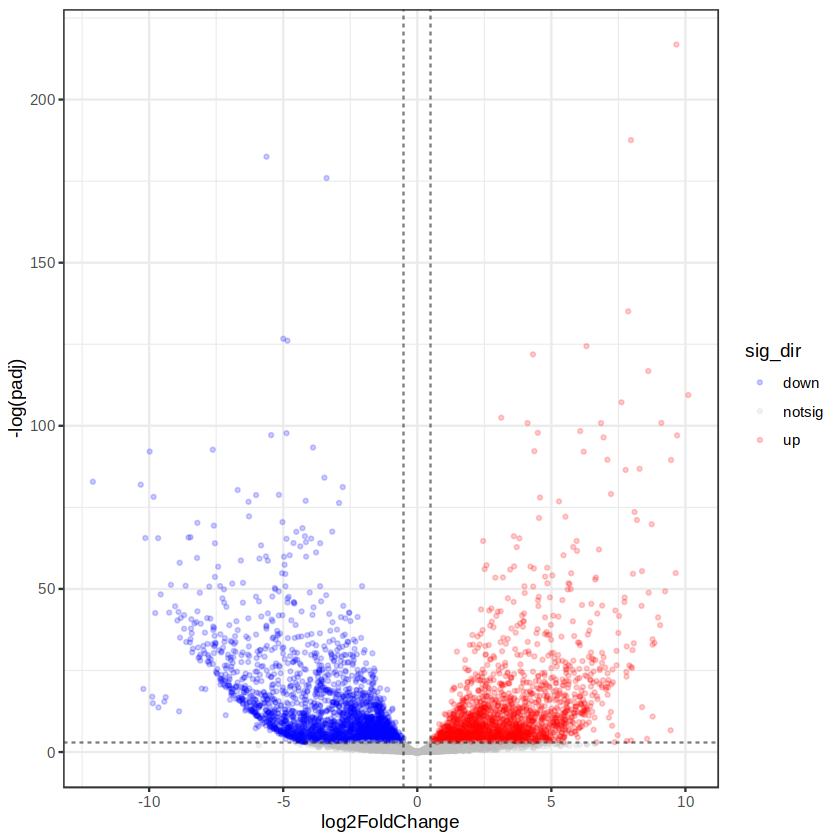

In [29]:
res_df=res
detable = res_df  %>%
    filter(!is.na(padj)) %>% 
    mutate(sig_dir = ifelse(padj<0.05 & log2FoldChange>0.5,"up",
                            ifelse(padj<0.05 & log2FoldChange < -0.5,"down","notsig"))) %>%
    mutate(delabel = ifelse( (sig_dir=="down" & -log(padj) > 15 | log2FoldChange < -2) | (sig_dir=="up" & (-log(padj) > 30 | log2FoldChange > 3) ), gene_name,""))
    
# create plot
detable %>% 
    filter(!is.na(padj)) %>%
    ggplot(aes(x=log2FoldChange, y=-log(padj), color = sig_dir, label=delabel)) + #
    geom_point(size = 0.75, alpha=0.2) +
    geom_hline(yintercept = -log(0.05), size = 0.5, alpha = 0.5, linetype="dashed")+
    geom_vline(xintercept = c(-0.5, 0.5), size = 0.5, alpha = 0.5, linetype="dashed") + 
#     geom_text_repel(size = 4) +
    scale_color_manual(values = c("notsig"="grey","up"="red","down"="blue"))+ theme_bw()